# Событийный анализ и A/A/B-тест в интернет-магазине

## Описание проекта

По заказу магазина продуктов питания нужно разобраться, как ведут себя пользователи его мобильного приложения. Необходимо изучить воронку продаж: узнать, сколько пользователей доходят до покупки и сколько - «застревает» на предыдущих шагах.

Также необходимо изучить результаты A/A/B-эксперимента, в ходе которого в приложении были изменены шрифты. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную - с новыми. Нужно выяснить, какой шрифт лучше.

Для выполнения проекта предоставлена таблица с логами, которая содержит такие данные: пользователь, номер группы в тесте, событие, дата и время события.

## <a name="0"> Структура проекта </a>

- [Загрузка данных и ознакомление с ними](#1)
- [Предобработка данных](#2)
- [Изучение и проверка данных](#3)
  - [Среднее количество событий на одного пользователя](#3.1)
  - [Анализ частоты событий во времени](#3.2)
  - [Исключение неполных данных](#3.3)
- [Воронка событий](#4)
  - [Типы событий и их частота](#4.1)
  - [Типы событий и количество пользователей](#4.2)
  - [Последовательность событий и конверсии](#4.3)
- [Результаты эксперимента](#5)
  - [Анализ однородности групп](#5.1)
  - [Воронка событий для групп](#5.2)
  - [Сравнение контрольных групп](#5.3)
  - [Сравнение тестовой группы с контрольными](#5.4)
  - [Сравнение тестовой группы с объединённой контрольной группой](#5.5)
  - [Сравнение трёх групп с помощью χ2-критерия](#5.6)
- [Общие выводы](#6)

## <a name="1"> Загрузка данных и ознакомление с ними </a>

Загрузим необходимые библиотеки для работы с таблицами, временем, для визуализации данных и проверки гипотез:

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as st 
import warnings
warnings.simplefilter('ignore')

Загрузим таблицу с данными и посмотрим на неё:

In [2]:
df = pd.read_csv('/Users/polzovatel/Desktop/logs_exp.csv', sep='\t')
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Таблица содержит логи действий пользователей, где:
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Посмотрим на типы данных в столбцах и количество пропусков:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


В таблице 244 126 строк, 4 столбца с типами object и int64, пропусков нет. Названия столбцов лучше привести к стилю snake_case, а данные в столбце EventTimestamp - к типу datetime. Сейчас EventTimestamp хранит дату, записанную в формате timestamp - то есть число, равное количеству секунд, прошедших с полуночи 1 января 1970. Для удобства восприятия лучше использовать тип datetime. Сделаем изменения на этапе предобработки данных.

## <a name="2"> Предобработка данных </a>

Приведём названия столбцов к стилю snake_case:

In [4]:
df.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']

Проверим наличие дублей:

In [5]:
df.duplicated().sum()

413

413 записей-дублей. Удалим их:

In [6]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Дублей не осталось.

Столбец event_timestamp приведём к типу datetime:

In [7]:
df['event_datetime'] = df['event_timestamp'].apply(dt.datetime.utcfromtimestamp)

Также создадим столбец с датой события (без времени):

In [8]:
df['event_date'] = df['event_datetime'].dt.floor('1D') 

Проверим, что в таблице названия столбцов поменялись на snake_case, появился столбец event_datetime с датой и временем события и столбец event_date с датой события:

In [9]:
df.head(1)

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25


Отлично! Всё, что хотели - появилось или изменилось. Теперь с таблицей будет удобнее работать. Можно приступать к изучению данных.

[В начало](#0)

## <a name="3"> Изучение и проверка данных </a>

### <a name="3.1"> Среднее количество событий на одного пользователя </a>

Посчитаем количество событий, которые хранит таблица. Так как в таблице каждому событию соответствует одна запись, то количество событий равно количеству записей: 

In [10]:
events_num = len(df)
events_num

243713

Посчитаем, сколько всего пользователей:

In [11]:
users_num = df['device_id_hash'].nunique()
users_num

7551

Теперь посчитаем, сколько в среднем событий приходится на пользователя:

In [12]:
avg_events_per_user = events_num / users_num
avg_events_per_user

32.27559263673685

В среднем каждый из 7551 пользователя совершает чуть больше 32 действий.

Построим гистограмму распределения событий по пользователям. Посмотрим, насколько среднее значение подходит для описания этого распределения.

Напишем функцию, которая строит гистограмму (она нам еще пригодятся в проекте) и выведем график:

In [13]:
def hist(column):
    plt.figure(figsize=(12, 3))
    plt.hist(column, bins=200, alpha=.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel) 
    plt.xticks(rotation=-30)
    plt.show()

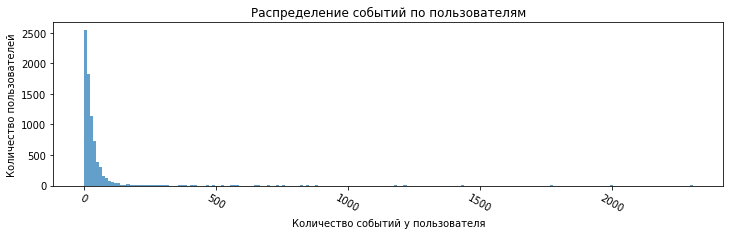

In [14]:
title = "Распределение событий по пользователям"
xlabel = "Количество событий у пользователя"
ylabel = "Количество пользователей"
hist(df.groupby('device_id_hash')['event_timestamp'].count())

Распределение сильно сплющено у нуля из-за выбросов - пользователей с количеством событий около 2000. Среднее - не лучшая мера центральной тенденции для описания такого распределения. Построим боксплот, на нём можно увидеть медиану:

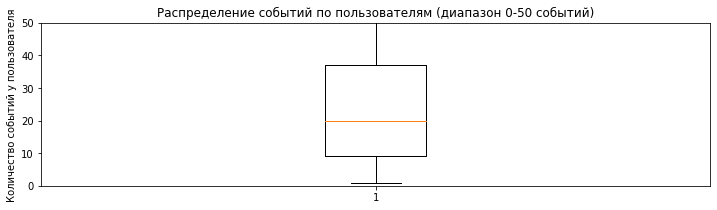

In [15]:
plt.figure(figsize=(12, 3))
plt.boxplot(df.groupby('device_id_hash')['event_timestamp'].count())
plt.title("Распределение событий по пользователям (диапазон 0-50 событий)")
plt.ylabel("Количество событий у пользователя")
plt.ylim(0, 50)
plt.show()

Для описания распределения больше подойдёт медиана, а она равна 20 событиям на одного пользователя.

### <a name="3.2"> Анализ частоты событий во времени </a>

Определим, данными за какой период мы располагаем:

In [16]:
df['event_datetime'].describe()

count                  243713
unique                 176654
top       2019-08-01 14:40:35
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: event_datetime, dtype: object

Самая ранняя дата - 25 июля 2019, самая поздняя - 7 августа 2019. У нас данные за 14 дней:

![](http://dl3.joxi.net/drive/2021/03/24/0046/2540/3033580/80/9bfd3a103e.jpg)

Теперь посмотрим, как записи распределены по этим 14 дням - равномерно или нет:

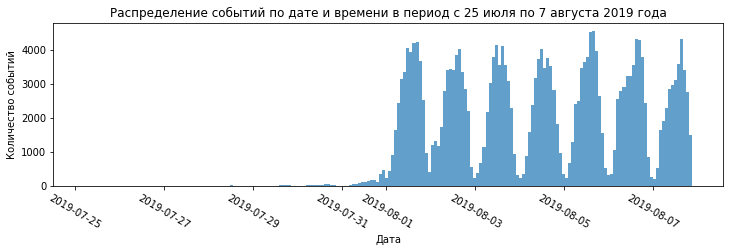

In [17]:
title = "Распределение событий по дате и времени в период с 25 июля по 7 августа 2019 года"
xlabel = "Дата"
ylabel = "Количество событий"
hist(df['event_datetime'])

На гистограмме видно, что:
- событий практически не было в период с 25 июля по 1 августа;
- есть 7 пиков в период с 1 по 7 августа - один пик на один день. Видно, что провалы между пиками приходятся на переходы между датами по оси x, то есть являются ночным временем. Это логично - большинство пользователей в это время спит и поэтому происходит меньше событий.

### <a name="3.3"> Исключение неполных данных </a>

Так как до 1 августа событий практически не было, то мы не будем рассматривать этот период. Рассмотрим только период, когда пользователи были активны - с 1 по 7 августа.

Посчитаем, сколько событий и пользователей мы потеряем при отсечении данных до 1 августа. Сначала посчитаем отсечённые события, то есть все событий, которые произошли ранее, чем 1 августа:

In [18]:
events_cut_num = len(df[df['event_date'] < '2019-08-01'])
events_cut_num

2826

Доля таких событий:

In [19]:
events_cut_num / events_num

0.011595606307418972

То есть мы отсекаем 2826 событий или 1,2% данных - не так уж и много. 

Теперь определим количество отсечённых пользователей. В данном случае мы не можем просто посчитать количество пользователей, у которых были события до 1 августа, так как у некоторых из них могут быть события и после 1 августа (включительно). То есть не все из этих пользователей будут отсечены. Правильно сначала посчитать количество пользователей, у которых есть события после 1 августа (включительно). И затем из общего количества пользователей вычесть посчитанное значение. Проведём эти расчёты.

Количество пользователей, у которых есть события после 1 августа (включительно):

In [20]:
users_uncut_num = df[df['event_date'] >= '2019-08-01']['device_id_hash'].nunique()
users_uncut_num

7534

Тогда количество пользователей, которых мы отсекаем при изучении периода с 1 по 7 августа:

In [21]:
users_cut_num = users_num - users_uncut_num
users_cut_num

17

Доля отсечённых пользователей:

In [22]:
users_cut_num / users_num

0.0022513574361011784

Таким образом, мы отсекаем 17 пользователей или 0,2% пользователей. При этом 7534 из 7551 пользователей были активны в период с 1 по 7 августа.

Количество отсечённых событий и пользователей оказалось небольшим, поэтому можем смело работать с новой таблицей с записями с 1 по 7 августа. Создадим такую таблицу и проверим, что данные в ней находятся в указанном промежутке:

In [23]:
df_filt = df[df['event_date'] >= '2019-08-01']
df_filt['event_datetime'].describe()

count                  240887
unique                 174044
top       2019-08-04 16:23:19
freq                        9
first     2019-08-01 00:07:28
last      2019-08-07 21:15:17
Name: event_datetime, dtype: object

Проверим, что остались пользователи из всех трёх экспериментальных групп:

In [24]:
df_filt['exp_id'].unique()

array([246, 247, 248])

[В начало](#0)

## <a name="4"> Воронка событий </a>

### <a name="4.1"> Типы событий и их частота </a>

Посмотрим, какие события есть в логах и как часто они встречаются:

In [25]:
df_filt['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Всего 5 типов событий, можно предположить, что они означают следующее:
- MainScreenAppear - открытие главной страницы;
- OffersScreenAppear - открытие страницы с предложениями;
- CartScreenAppear - открытие страницы, где заполняются данные платёжной карты;
- PaymentScreenSuccessful - открытие страницы об успешной оплате;
- Tutorial - открытие страницы с дополнительной информацией о приложении.

Построим диаграмму, чтобы вызуально сравнить частоту событий между собой:

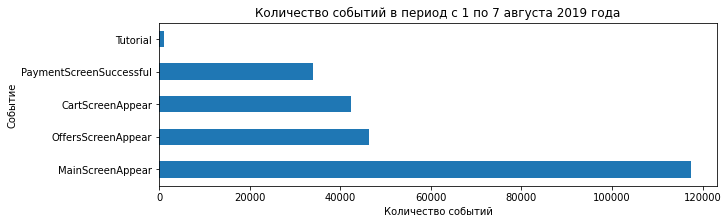

In [26]:
events_per_event_names = df_filt['event_name'].value_counts().reset_index()
events_per_event_names.columns = ['event_name', 'events']
events_per_event_names.plot(x='event_name',  y='events', kind='barh', figsize=(10, 3), legend=False)
plt.title("Количество событий в период с 1 по 7 августа 2019 года")
plt.xlabel("Количество событий")
plt.ylabel("Событие") 
plt.show()

Главная страница открывалась почти 120 000 раз, но страница с предложениями - менее 50 000 раз. Сильное падение, учитывая, что основное предназначение приложения - заказ товаров. Зафиксируем эту проблему и вернёмся к ней чуть позже.

Страницу Tutorial посетили совсем немного раз в сравнении с другими страницами - около 1000. Скорее всего ей пользуются только те посетители, которые столкнулись с проблемой в работе приложения или хотят узнать дополнительную информацию. 

### <a name="4.2"> Типы событий и количество пользователей </a>

Посчитаем, сколько пользователей совершали каждое из пяти событий. Для этого сгруппируем таблицу df_filt по событиям и посчитаем для каждого события количество уникальных пользователей:

In [27]:
users_per_event_names = df_filt.groupby('event_name')['device_id_hash'].nunique().reset_index()\
                               .sort_values('device_id_hash', ascending=False)
users_per_event_names.columns = ['event_name', 'users']
users_per_event_names

,event_name,users
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Посчитаем долю пользователей, которые хоть раз совершали событие. Для этого поделим количество пользователей для каждого события на общее количество пользователей в период с 1 по 7 августа (значение хранит переменная users_uncut_num):

In [28]:
users_per_event_names['share_of_total_users'] = round(users_per_event_names['users'] / users_uncut_num, 3)
users_per_event_names = users_per_event_names.sort_values('users', ascending=False)\
                                             .reset_index(drop=True)
users_per_event_names

,event_name,users,share_of_total_users
0,MainScreenAppear,7419,0.985
1,OffersScreenAppear,4593,0.610
2,CartScreenAppear,3734,0.496
3,PaymentScreenSuccessful,3539,0.470
4,Tutorial,840,0.111


Получается, что на главную страницу зашли почти все пользователи (событие MainScreenAppear). А на страницу с дополнительной информацией (событие Tutorial) зашли только 11% пользователей.

### <a name="4.3"> Последовательность событий и конверсии </a>

События по количеству пользователей расставлены в той же последовательности, что и события по частоте встречаемости. И по цифрам и по логике названий события выстраиваются в такую воронку:
- MainScreenAppear - посетил главную страницу;
- OffersScreenAppear - посмотрел предложения;
- CartScreenAppear - открыл форму оплаты;
- PaymentScreenSuccessful - оплата прошла.

Причём событие Tutorial можно исключить из воронки событий, так как оно может произойти на любом из этапов воронки. 

In [29]:
users_per_event_names = users_per_event_names.drop(4)
users_per_event_names

,event_name,users,share_of_total_users
0,MainScreenAppear,7419,0.985
1,OffersScreenAppear,4593,0.610
2,CartScreenAppear,3734,0.496
3,PaymentScreenSuccessful,3539,0.470


Посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). Для этого напишем цикл, который рассчитает конверсию каждого шага и наполнит ими список. Далее этот список мы добавим в таблицу как новую колонку.

In [30]:
cr = [1]
for i in range(3):
    cr.append(round(users_per_event_names.loc[i+1, 'users'] / users_per_event_names.loc[i, 'users'], 3))

У нас получились такие конверсии:

In [31]:
cr

[1, 0.619, 0.813, 0.948]

Добавим их в таблицу:

In [32]:
users_per_event_names['cr'] = cr
users_per_event_names

,event_name,users,share_of_total_users,cr
0,MainScreenAppear,7419,0.985,1.000
1,OffersScreenAppear,4593,0.610,0.619
2,CartScreenAppear,3734,0.496,0.813
3,PaymentScreenSuccessful,3539,0.470,0.948


Чтобы визуально оценить конверсию каждого шага и конверсии с шага на шаг, построим диаграммы. Напишем функцию и выведем графики:

In [33]:
def barplot(data, x, y, title, xlabel, ylabel, legend):
    data.plot(x=x, y=y, kind='bar', figsize=(10, 3), alpha=.7, legend=legend)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel) 
    plt.xticks(rotation=0)
    plt.show()

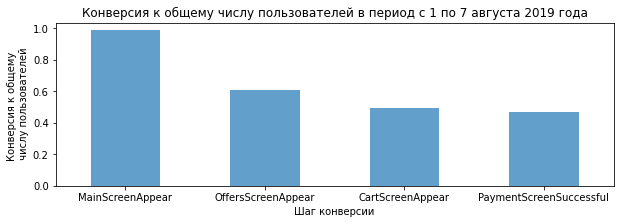

In [34]:
title = "Конверсия к общему числу пользователей в период с 1 по 7 августа 2019 года"
xlabel = "Шаг конверсии"
ylabel = "Конверсия к общему \n числу пользователей"
barplot(users_per_event_names, 'event_name', 'share_of_total_users', title, xlabel, ylabel, False)

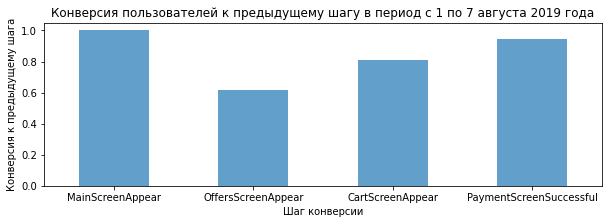

In [35]:
title = "Конверсия пользователей к предыдущему шагу в период с 1 по 7 августа 2019 года"
xlabel = "Шаг конверсии"
ylabel = "Конверсия к предыдущему шага"
barplot(users_per_event_names, 'event_name', 'cr', title, xlabel, ylabel, False)

На втором графике и из таблицы users_per_event_names видно, что только 62% от количества пользователей, зашедших на главную страницу, попадают на страницу с предложениями. 38% мы теряем сразу на первом шаге - пользователи открывают приложение и даже не доходят до товаров. Скорее всего есть проблема с главной страницей: возможно, что недостаточно ясно, как перейти в раздел с товарами, или кнопка работает не на всех устройствах. На это надо обратить внимание разработчиков и тестировщиков.

Из тех, кто посмотрел товары, на страницу оплаты попадают 81%: 4 из 5 пользователей находят нужный им товар. Из тех, кто попал на страницу оплаты, удачно оплачивают 95%. Возможно, оставшиеся 5% передумывают в последний момент или временно откладывают покупку. Это кажется нормальным и цифра не такая большая.

На первом графике видно, что от первого события до последнего доходит примерно 47% - каждый второй посетитель совершает покупку. Если устранить проблему с переходом на страницу предложений, то конверсия посетителей в сделки возрастёт еще сильнее.

[В начало](#0)

## <a name="5"> Результаты эксперимента </a>

### <a name="5.1"> Анализ однородности групп </a>

Теперь изучим результаты A/A/B-эксперимента. Для начала посчитаем, сколько пользователей в каждой экспериментальной группе:

In [36]:
users_per_groups = df_filt.groupby('exp_id')['device_id_hash'].nunique()
users_per_groups

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

Группы наполнены поровну, примерно по 2,5 тыс. пользователей в каждой. Необходимо также проверить, что события в группах совершались однородно в течение времени, чтобы не получилось так, что в одной группе оказались пользователи, которые совершают действия ночью или в выходные дни, а в другой группе - днём или в будние. Для этого построим распределение событий по времени для каждой группы:

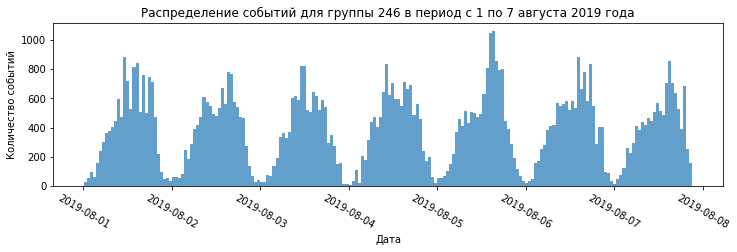

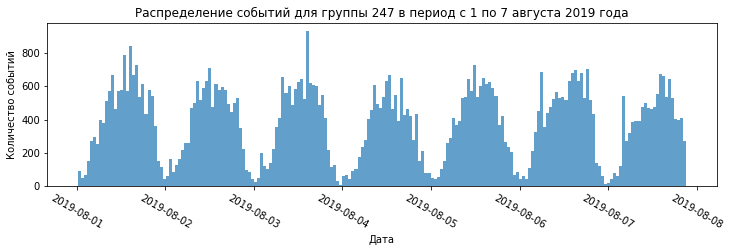

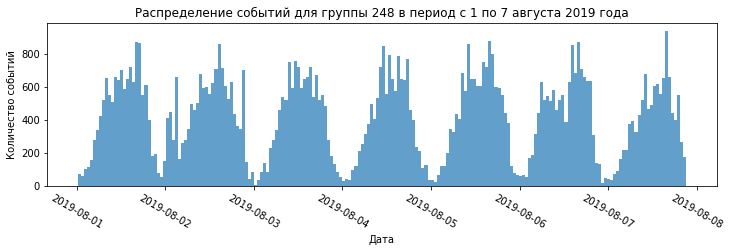

In [37]:
for i in [246, 247, 248]:
    title = f"Распределение событий для группы {i} в период с 1 по 7 августа 2019 года"
    xlabel = "Дата"
    ylabel = "Количество событий"
    hist(df_filt[df_filt['exp_id'] == i]['event_datetime'])

Видно, что пользователи во всех группах имеют похожее поведение по нарастанию и затуханию активности. Это значит, что группы равномерно наполнены пользователями, без перекосов в поведении для какой-либо из групп.

### <a name="5.2"> Воронка событий для групп </a>

Ранее мы построили воронку событий для всех пользователей. Теперь построим такую же воронку, но с разбивкой пользователей по группам:

In [38]:
users_per_groups_events = df_filt.pivot_table(index='event_name', columns='exp_id'
                                       , values='device_id_hash', aggfunc='nunique')\
                                        .reset_index()\
                                        .sort_values(246, ascending=False)
users_per_groups_events.columns = ['event_name', 246, 247, 248]
users_per_groups_events = users_per_groups_events.drop(4)
users_per_groups_events = users_per_groups_events.reset_index(drop=True)
users_per_groups_events

,event_name,246,247,248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


Добавим столбцы, которые будут содержать долю пользователей, совершивших событие, от общего количество пользователей в группах:

In [39]:
users_per_groups_events['share_of_users246'] = round(users_per_groups_events[246] / users_per_groups[246]
                                                      , 3)
users_per_groups_events['share_of_users247'] = round(users_per_groups_events[247] / users_per_groups[247]
                                                      , 3)
users_per_groups_events['share_of_users248'] = round(users_per_groups_events[248] / users_per_groups[248]
                                                      , 3)

In [40]:
users_per_groups_events

,event_name,246,247,248,share_of_users246,share_of_users247,share_of_users248
0,MainScreenAppear,2450,2476,2493,0.986,0.985,0.983
1,OffersScreenAppear,1542,1520,1531,0.621,0.605,0.603
2,CartScreenAppear,1266,1238,1230,0.510,0.493,0.485
3,PaymentScreenSuccessful,1200,1158,1181,0.483,0.461,0.466


Теперь посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем) для каждой группы:

In [41]:
for i in [246, 247, 248]:
    cr = [1]
    for j in range(3):
        cr.append(round(users_per_groups_events.loc[j+1, i] / users_per_groups_events.loc[j, i], 3))
    users_per_groups_events[f'cr{i}'] = cr

In [42]:
users_per_groups_events

,event_name,246,247,248,share_of_users246,share_of_users247,share_of_users248,cr246,cr247,cr248
0,MainScreenAppear,2450,2476,2493,0.986,0.985,0.983,1.000,1.000,1.000
1,OffersScreenAppear,1542,1520,1531,0.621,0.605,0.603,0.629,0.614,0.614
2,CartScreenAppear,1266,1238,1230,0.510,0.493,0.485,0.821,0.814,0.803
3,PaymentScreenSuccessful,1200,1158,1181,0.483,0.461,0.466,0.948,0.935,0.960


Чтобы визуально сравнить группы по конверсии каждого шага и конверсии с шага на шаг, построим диаграммы:

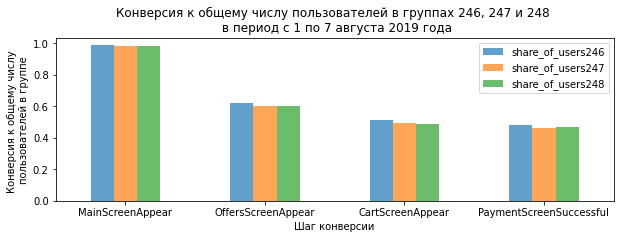

In [43]:
title = "Конверсия к общему числу пользователей в группах 246, 247 и 248 \n в период с 1 по 7 августа 2019 года"
xlabel = "Шаг конверсии"
ylabel = "Конверсия к общему числу \nпользователей в группе"
barplot(users_per_groups_events, 'event_name'
        , ['share_of_users246', 'share_of_users247', 'share_of_users248']
        , title, xlabel, ylabel, True)

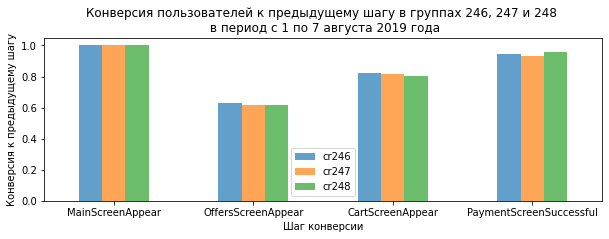

In [44]:
title = "Конверсия пользователей к предыдущему шагу в группах 246, 247 и 248 \n в период с 1 по 7 августа 2019 года"
xlabel = "Шаг конверсии"
ylabel = "Конверсия к предыдущему шагу"
barplot(users_per_groups_events, 'event_name', ['cr246', 'cr247', 'cr248'], title, xlabel, ylabel, True)

Столбцы, то есть группы, визуально практически не отличаются друг от друга ни для одной из конверсий. Складывется ощущение, что изменение шрифтов в приложении не привело к значимой разнице в конверсиях. Однако, чтобы утверждать это более научно, не только опираясь на ощущения от просмотра диаграммы, проверим гипотезу об отсутствии влияния шрифтов с помощью статистического анализа. 

[В начало](#0)

### <a name="5.3"> Сравнение контрольных групп </a>

Сначала сравним между собой две контрольные группы 246 и 247, чтобы убедиться, что пользователи в них корректно поделены. Мы уже ранее оценивали корректность разделения пользователей в группах, когда смотрели распределение событий во времени для каждой группы, а теперь сделаем проверку по конверсиям в группах. 

#### Формулировка гипотез

Выберем самое популярное событие в обеих контрольных выборках (MainScreenAppear) и сравним доли пользователей в группах, совершивших это событие. Проверять будем следующие гипотезы:
- Нулевая гипотеза (H0): доли пользователей, совершивших событие MainScreenAppear, в группе 246 и 247 не отличаются, так как обе группы относятся к общей генеральной совокупности с единой общей конверсией (долей), а полученное различие в долях групп является случайным.
- Альтернативная гипотеза (H1): полученное различие в долях групп вызвано тем, что группы относятся к разным генеральным совокупностях. Такое может быть, только если мы неправильно разделили пользователей на две контрольные группы или совершили другие ошибки в организации теста (например, группы видели разные варианты приложения).

#### Выбор статистического критерия

Проверку различий в конверсиях (долях) для двух выборок проводят с помощью z-значения - то есть значения, которое показывает на сколько стандартных отклонений наше различие в конверсиях отклоняется от нуля нормального стандартизированного распределения. Если принять нулевую гипотезу верной, то z-значение рассчитывается следующим образом:

$$z = \frac{(P_A - P_B)}{\sqrt{P(1-P)(1/n_A + 1/n_B)}}$$

где $P_A$ и $P_B$ - конверсия в группах, $P$ - общая конверсия для двух групп, $n_A$ и $n_B$ - количество посетителей в группах.

#### Выбор критического значения альфа

Критическим значением альфа обычно принимают 0,05. Такой уровень альфа позволяет нам рассчитывать, что примерно в 19 из 20 проверок не будет выявлено статистического различия при условии верности нулевой гипотезы. Вероятность ошибки - 5%.

Если проводить проверки нескольких гипотез, то вероятность совершить ошибку хотя бы раз будет суммироваться: при проверке двух гипотез вероятность ошибки составит 10%, а при проверке 10 гипотез - уже 50%. Соответственно, если мы проверим 20 гипотез, то весьма вероятно, что будет совершена хотя бы одна ошибка.

Чтобы избежать ошибки, вводят поправку Бонферрони, при которой критическое значение альфа уменьшают в то количество раз, сколько проверок мы проводим. Поэтому, чтобы определить альфа, нужно посчитать, сколько проверок мы планируем сделать.

Проверки:
- сравнение долей пользователей для каждого события между контрольными группами 246 и 247 (4 проверки);
- сравнение долей пользователей для каждого события между контрольной группой 246 и тестовой группой 248 (4 проверки);
- сравнение долей пользователей для каждого события между контрольной группой 247 и тестовой группой 248 (4 проверки);
- сравнение долей пользователей для каждого события между объединённой контрольной группой (246 и 247) и тестовой группой 248 (4 проверки).

Итого 16 проверок. Значит примем альфа равным:  

In [45]:
alpha = .05 / 16
alpha

0.003125

#### Расчёты

Воспользуемся формулой для расчёта z-значения и найдём его:

In [46]:
# количество пользователей в группе 246 и 247:
n_246 = users_per_groups[246] 
n_247 = users_per_groups[247] 
# доли пользователей, совершивших событие MainScreenAppear, в группе 246 и 247:
p_246 = users_per_groups_events[246][0] / n_246
p_247 = users_per_groups_events[247][0] / n_247
# общая доля пользователей, совершивших событие MainScreenAppear, для обеих групп 246 и 247:
p = (users_per_groups_events[246][0] + users_per_groups_events[247][0]) / (n_246 + n_247) 
# z-значение:
z_value = (p_246 - p_247) / (p * (1 - p) * (1 / n_246 + 1 / n_247))**.5
z_value

0.3093441851418436

На основе z-значения найдём p-значение, то есть вероятность получить наше различие в долях или ещё более сильное различие при условии верности нулевой гипотезы:

In [47]:
# зададим стандартное нормальное распределение:
distr = st.norm(0, 1)
# p-значение:
p_value = (1 - distr.cdf(abs(z_value))) * 2
p_value

0.7570597232046099

Так как p-значение намного больше критического значения альфа, то у нас нет никаких оснований отклонить нулевую гипотезу. Это означает, что значимых различий в долях пользователей, совершивших событие MainScreenAppear, в группах 246 и 247 нет. 

Для упрощения расчёта z-значения и p-значения можно воспользоваться функцией proportions_ztest библиотеки statsmodels.stats.proportion. Она принимает два аргумента: количество пользователей, совершивших действие, в двух группах и размеры двух групп. Проведём расчёты с помощью этой функции и сравним доли пользователей для каждого события в контрольных группах.

Создадим словарь с названиями событий и индексами в таблице users_per_groups_events:

In [48]:
ind_events = dict(users_per_groups_events['event_name'])
events_ind = {v: k for k, v in ind_events.items()} # меняем местами ключи и значения
events_ind

{'MainScreenAppear': 0,
 'OffersScreenAppear': 1,
 'CartScreenAppear': 2,
 'PaymentScreenSuccessful': 3}

Напишем функцию, которая будет сравнивать доли в выборках и возвращать z-значение и p-значение:

In [49]:
def compare_shares(event_name, group1, group2):
    ind = events_ind[event_name]
    count = [users_per_groups_events[group1][ind], users_per_groups_events[group2][ind]]
    nobs = [users_per_groups[group1], users_per_groups[group2]]
    return proportions_ztest(count, nobs)

Напишем функцию, которая вернёт результаты проверки гипотез для всех событий:

In [50]:
def all_calc(group1, group2):
    group1, group2 = group1, group2
    for event_name in events_ind.keys():
        print(f'z-значение и p-значение при сравнении долей пользователей, совершивших событие {event_name}:')
        zstat, p_value = compare_shares(event_name, group1, group2)
        print(zstat, p_value)
        if p_value >= alpha:
            print('Статистически значимых различий в долях между группами нет. Нет оснований отвергнуть нулевую гипотезу.')
        else:
            print('Между группами есть статистически значимые различия в долях. Принимаем альтернативную гипотезу.')
        print()

In [51]:
all_calc(246, 247)

z-значение и p-значение при сравнении долей пользователей, совершивших событие MainScreenAppear:
0.3093441851418436 0.7570597232046099
Статистически значимых различий в долях между группами нет. Нет оснований отвергнуть нулевую гипотезу.

z-значение и p-значение при сравнении долей пользователей, совершивших событие OffersScreenAppear:
1.154987713610383 0.2480954578522181
Статистически значимых различий в долях между группами нет. Нет оснований отвергнуть нулевую гипотезу.

z-значение и p-значение при сравнении долей пользователей, совершивших событие CartScreenAppear:
1.203368576486285 0.22883372237997213
Статистически значимых различий в долях между группами нет. Нет оснований отвергнуть нулевую гипотезу.

z-значение и p-значение при сравнении долей пользователей, совершивших событие PaymentScreenSuccessful:
1.5779948491596598 0.11456679313141847
Статистически значимых различий в долях между группами нет. Нет оснований отвергнуть нулевую гипотезу.



При использовании функции proportions_ztest z-значение и p-значение для события MainScreenAppear оказались такими же, как при расчёте по формуле z-значения, который мы делали чуть ранее. Это подтверждает, что функция proportions_ztest сработала корректно.

Как видно из расчётов, контрольные группы не имеют значимых различий. Это означает, что разбивка на группы и сам тест проведены корректно.

### <a name="5.4"> Сравнение тестовой группы с контрольными </a>

Теперь сравним тестовую группу с контрольными. Сформулируем гипотезы:

#### Формулировка гипотез

- Нулевая гипотеза (H0): доли пользователей, совершивших событие, в контрольной группе (246/247) и тестовой группе (248) не отличаются, так как обе группы и их конверсии относятся к общей генеральной совокупности, а полученное различие в долях групп является случайным.
- Альтернативная гипотеза (H1): полученное различие в долях групп вызвано тем, что группы и их конверсии относятся к разным генеральным совокупностях. Различие в генеральных совокупностях вызвано изменением шрифтов приложения.

#### Расчёты

Сравним контрольную группу 246 и тестовую группу 248:

In [52]:
all_calc(246, 248)

z-значение и p-значение при сравнении долей пользователей, совершивших событие MainScreenAppear:
1.0472762353383693 0.2949721933554553
Статистически значимых различий в долях между группами нет. Нет оснований отвергнуть нулевую гипотезу.

z-значение и p-значение при сравнении долей пользователей, совершивших событие OffersScreenAppear:
1.2580821335711887 0.20836205402738917
Статистически значимых различий в долях между группами нет. Нет оснований отвергнуть нулевую гипотезу.

z-значение и p-значение при сравнении долей пользователей, совершивших событие CartScreenAppear:
1.7598736474548398 0.07842923237520125
Статистически значимых различий в долях между группами нет. Нет оснований отвергнуть нулевую гипотезу.

z-значение и p-значение при сравнении долей пользователей, совершивших событие PaymentScreenSuccessful:
1.2473878277158326 0.21225532756977972
Статистически значимых различий в долях между группами нет. Нет оснований отвергнуть нулевую гипотезу.



Сравним контрольную группу 247 и тестовую группу 248:

In [53]:
all_calc(247, 248)

z-значение и p-значение при сравнении долей пользователей, совершивших событие MainScreenAppear:
0.740980338642352 0.45870536166215137
Статистически значимых различий в долях между группами нет. Нет оснований отвергнуть нулевую гипотезу.

z-значение и p-значение при сравнении долей пользователей, совершивших событие OffersScreenAppear:
0.1007086015299871 0.919781783059226
Статистически значимых различий в долях между группами нет. Нет оснований отвергнуть нулевую гипотезу.

z-значение и p-значение при сравнении долей пользователей, совершивших событие CartScreenAppear:
0.5554019078073092 0.5786197879539782
Статистически значимых различий в долях между группами нет. Нет оснований отвергнуть нулевую гипотезу.

z-значение и p-значение при сравнении долей пользователей, совершивших событие PaymentScreenSuccessful:
-0.3353759529753951 0.7373415053803964
Статистически значимых различий в долях между группами нет. Нет оснований отвергнуть нулевую гипотезу.



Статистически значимых различий в конверсиях не выявлено. 248 группа не отличается ни от 246, ни от 247. Изменение шрифтов не привело к изменению конверсий.

### <a name="5.5"> Сравнение тестовой группы с объединённой контрольной группой </a>

Теперь сравним тестовую группу с объединённой контрольной. Рассчитаем количество пользователей в группах 246 и 247:

In [54]:
users_per_groups

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

In [55]:
users_per_groups['246plus247'] = users_per_groups[246] + users_per_groups[247]
users_per_groups['246plus247']

4997

Добавим столбец с суммарным количеством пользователей на каждом шаге для 246 и 247 групп:

In [56]:
users_per_groups_events['246plus247'] = users_per_groups_events[246] + users_per_groups_events[247]
users_per_groups_events

,event_name,246,247,248,share_of_users246,share_of_users247,share_of_users248,cr246,cr247,cr248,246plus247
0,MainScreenAppear,2450,2476,2493,0.986,0.985,0.983,1.000,1.000,1.000,4926
1,OffersScreenAppear,1542,1520,1531,0.621,0.605,0.603,0.629,0.614,0.614,3062
2,CartScreenAppear,1266,1238,1230,0.510,0.493,0.485,0.821,0.814,0.803,2504
3,PaymentScreenSuccessful,1200,1158,1181,0.483,0.461,0.466,0.948,0.935,0.960,2358


#### Формулировка гипотез

- Нулевая гипотеза (H0): доли пользователей, совершивших событие, в объединённой контрольной группе (246+247) и тестовой группе (248) не отличаются, так как обе группы и их конверсии относятся к общей генеральной совокупности, а полученное различие в долях групп является случайным.
- Альтернативная гипотеза (H1): полученное различие в долях групп вызвано тем, что группы и их конверсии относятся к разным генеральным совокупностях. Различие в генеральных совокупностях вызвано изменением шрифтов приложения.

#### Расчёты

Сравним группы по конверсии в каждое событие:

In [57]:
all_calc('246plus247', 248)

z-значение и p-значение при сравнении долей пользователей, совершивших событие MainScreenAppear:
1.048854111361149 0.29424526837179577
Статистически значимых различий в долях между группами нет. Нет оснований отвергнуть нулевую гипотезу.

z-значение и p-значение при сравнении долей пользователей, совершивших событие OffersScreenAppear:
0.7819303684733905 0.43425549655188245
Статистически значимых различий в долях между группами нет. Нет оснований отвергнуть нулевую гипотезу.

z-значение и p-значение при сравнении долей пользователей, совершивших событие CartScreenAppear:
1.3353593793146474 0.18175875284404386
Статистически значимых различий в долях между группами нет. Нет оснований отвергнуть нулевую гипотезу.

z-значение и p-значение при сравнении долей пользователей, совершивших событие PaymentScreenSuccessful:
0.5237830725856985 0.6004294282308703
Статистически значимых различий в долях между группами нет. Нет оснований отвергнуть нулевую гипотезу.



Статистически значимых различий между конверсиями тестовой и объединённой контрольной групп нет. Это означает, что изменение шрифтов не повлияло на конверсию. Менять шрифт смысла нет, можно оставить прежний.

[В начало](#0)

### <a name="5.6"> Сравнение трёх групп с помощью χ2-критерия </a>

Сравнивать различия конверсий в группах можно не только с помощью z-значения. Когда групп несколько и есть подозрения, что между ними нет различий (как в нашем случае), можно применить χ2-критерий. Этот критерий покажет, есть ли среди сравниваемых групп хотя бы одна значимо отличающаяся.

Проверим, есть ли различие между группами в конверсии, например, для события PaymentScreenSuccessful. 

Последующие расчёты проведены на основании [данной статьи](https://baguzin.ru/wp/primenenie-2-kriteriya-dlya-proverki-gi/).

#### Формулировка гипотез

- Нулевая гипотеза (H0): доли пользователей, совершивших событие PaymentScreenSuccessful, в контрольных группах (246 и 247) и тестовой группе (248) не отличаются, так как все три группы и их конверсии относятся к общей генеральной совокупности, а полученное различие в долях групп является случайным.
- Альтернативная гипотеза (H1): полученное различие в долях групп вызвано тем, что группы и их конверсии относятся к разным генеральным совокупностях. Различие в генеральных совокупностях вызвано изменением шрифтов приложения.

#### Выбор критического значения альфа

Критическим значением альфа примем 0,05, так как мы проведём только одну проверку:

#### Расчёты

Чтобы проверить различие в конверсиях групп, нужно построить таблицы сопряжённости с наблюдаемыми и ожидаемыми конверсиями. Строить такие таблицы и проводить с ними расчёты удобнее в google spreadsheets, поэтому здесь выложу скриншоты, а сами расчёты находятся [тут](https://docs.google.com/spreadsheets/d/1OaVfBAjQ9ectzsRorwzOHe0Jrt-6RuHZU2_vvwFkv7w/edit?usp=sharing).

Сначала построим таблицу с наблюдаемыми конверсиями пользователей в событие PaymentScreenSuccessful:

![](http://dl3.joxi.net/drive/2021/03/24/0046/2540/3033580/80/d1381604f1.jpg)

Теперь рассчитаем ожидаемую долю пользователей, совершивших событие PaymentScreenSuccessful по формуле:

$$\frac{\sum_{группа=246}^{248} {Совершившие}\;{событие}}{\sum_{группа=246}^{248} {Всего}\;{пользователей}}$$

Значение составит 0,47. На основе этого значения составим таблицу с ожидаемыми конверсиями пользователей в событие PaymentScreenSuccessful:

![](http://dl4.joxi.net/drive/2021/03/24/0046/2540/3033580/80/fd4f01342e.jpg)

Рассчитаем χ2-значение по формуле:

$$χ^2 =\sum_{группа=246}^{248}\frac{({Наблюдаемое}\;{число} - {Ожидаемое}\;{число})^2}{{Ожидаемое}\;{число}}$$

![](http://dl4.joxi.net/drive/2021/03/24/0046/2540/3033580/80/10ffdd54f3.jpg)

Количество степеней свободы у χ2-распределения считается по формуле:

$$df =(n - 1)(m - 1)$$

где $n$ - число сравниваемых групп (их 3: 246, 247 и 248), а $m$ - число возможных исходов (совершил событие и не совершил событие, то есть 2). Таким образом, $df$ равно 2. 

Теперь воспользуемся специальным [калькулятором распределений](https://gallery.shinyapps.io/dist_calc/), где выберем распределение χ2, укажем число степеней свободы, равное двум, и χ2-значение, равное 2,766. В результате получим p-значение, равное 0,25:

![](http://dl4.joxi.net/drive/2021/03/24/0046/2540/3033580/80/9263f8ee9d.jpg)

Такое p-значение означает, что вероятность получить χ2-значение, равное 2,766, или ещё большее составляет 25%. Иными словами, вероятность получить наблюдаемое (или ещё большее) различие в конверсиях между группами 246, 247 и 248 составляет 25% при условии верности нулевой гипотезы. Так как это значительно больше критического значения альфа, равного 5%, то принимаем нулевую гипотезу, то есть конверсии в событие PaymentScreenSuccessful между тремя группами значимо не отличаются.

Результат проверки с помощью χ2-критерия совпал с результатом проверки с помощью z-значения: конверсии во всех трёх группах не отличаются, то есть изменение шрифта не влияет на конверсию. 

## <a name="6"> Общие выводы </a>

- За 2 недели теста (с 25 июля по 7 августа 2019 года) произошло 244 126 событий 7551 пользователем. В среднем каждый из пользователей совершил чуть больше 32 действий, а медиана по количеству событий у одного пользователя - 20;
- В первую неделю событий практически не было, поэтому для анализа взят усечённый период с 1 по 7 августа;
- Среди событий встречаются 5 типов, 4 из которых выстраиваются в воронку: MainScreenAppear (открытие главной страницы) -> OffersScreenAppear (открытие страницы с предложениями) -> CartScreenAppear (открытие страницы, где заполняются данные платёжной карты) -> PaymentScreenSuccessful (открытие страницы об успешной оплате). Пятое событие, Tutorial (открытие страницы с дополнительной информацией о приложении), к воронке не относится, так как может произойти на любом её этапе;
- Только 62% от количества пользователей, зашедших на главную страницу, попадают на страницу с предложениями. 38% мы теряем сразу на первом шаге - пользователи открывают приложение и даже не доходят до товаров. Скорее всего есть проблема с главной страницей: возможно, недостаточно ясно, как перейти в раздел с товарами, или кнопка работает не на всех устройствах. На это надо обратить внимание разработчиков и тестировщиков;
- Из тех, кто посмотрел товары, на страницу оплаты попадают 81%: 4 из 5 пользователей находят нужный им товар и готовы покупать. Хороший показатель;
- Из тех, кто попал на страницу оплаты, удачно оплачивают 95%. Возможно, оставшиеся 5% передумывают в последний момент или временно откладывают покупку. Это кажется нормальным: цифра не такая большая;
- От первого события до последнего доходит примерно 47% - каждый второй посетитель совершает покупку. Если устранить проблему с переходом на страницу предложений, то конверсия посетителей в сделки возрастёт еще сильнее;
- Значимых различий в конверсиях двух контрольных групп (246 и 247) не выявлено. Это означает, что разбивка на группы и сам тест проведены корректно;
- Статистически значимых различий в конверсиях тестовой 248 и контрольной 246 и 247 группы не выявлено. Также не выявлено различий между тестовой 248 и объединённой 246 и 247 группами. Изменение шрифтов не привело к изменению конверсий. 

Если короче, то можно сделать 2 вывода:
- нужно разобраться, почему многие посетители не попадают на страницу с предложениями;
- шрифты менять нет смысла, конверсия не меняется.

[В начало](#0)